Image Deconvolution (ADMM Plug-and-Play Priors w/ DnCNN)
========================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve
an image deconvolution problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using DnCNN
<cite data-cite="zhang-2017-dncnn"/> as a denoiser.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=512)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Set up forward operator and test signal consisting of blurred signal
with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Load DnCNN denoiser and create map object.

In [4]:
λ = 15.0 / 255  # regularization strength
g = λ * functional.DnCNN("17M")

Set up an ADMM solver.

In [5]:
ρ = 1.0  # ADMM penalty parameter
maxiter = 10  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
C = linop.Identity(x_gt.shape)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.T @ y,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 30}),
    verbose=True,
)

Run the solver.

In [6]:
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Iter  Time      Primal Rsdl  Dual Rsdl
--------------------------------------
   0   2.9e+00    1.330e+01  1.563e+01
   1   3.0e+00    5.169e+00  1.098e+01
   2   3.0e+00    2.300e+00  8.613e+00
   3   3.1e+00    1.727e+00  6.959e+00


   4   3.1e+00    1.474e+00  5.638e+00
   5   3.2e+00    1.256e+00  4.570e+00
   6   3.2e+00    1.045e+00  3.729e+00
   7   3.3e+00    8.523e-01  3.083e+00
   8   3.3e+00    6.863e-01  2.596e+00


   9   3.4e+00    5.513e-01  2.224e+00


Show the recovered image.

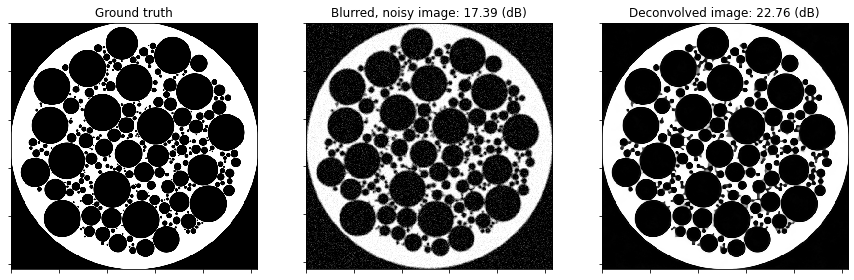

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
y = snp.clip(y, 0, 1)
nc = n // 2
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

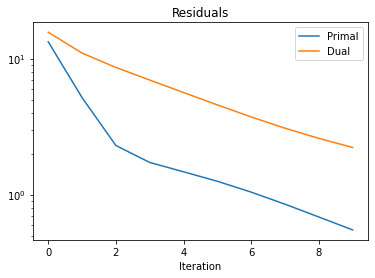

In [8]:
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)